In [ ]:
# Using transfer learning to see if I can get better results with a pre-trained model
# Load VGG16 model without top layer and freeze its layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size) + (3,))

# Freeze the layers of VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Create new model and add VGG16 base model
model = Sequential()
model.add(base_model)
model.add(Flatten())

# Add new fully connected layers
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

# Print model summary
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//validation_generator.batch_size, 
                    verbose=2,
                    validation_freq=1,
                    callbacks=[early_stop],
                    class_weight=class_weights)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 7)                 57351     
                                                                 
Total params: 14,772,039
Trainable params: 57,351
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
42/42 - 624s - loss: 1.3615 - acc: 0.4905 - val_loss: 0.8757 - val_acc: 0.6719 - 624s/epoch - 15s/step
Epoch 2/50
42/42 - 592s - loss: 0.9911 - acc: 0.6403 - val_loss: 0.8924 - val_acc: 0.6562 - 592s/epoch - 14s/step
Epoch 3/50

In [ ]:
# Saving model
model.save("recycling_cnn_2.h5")

In [ ]:
# Define test data generator and get test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle=False, 
                                                  target_size=(image_size, image_size), 
                                                  batch_size=batch_size, 
                                                  class_mode='categorical')

# Evaluating the model on the test set
test_x, test_y = next(test_generator)
results_test = model.evaluate(test_x, test_y)

# Much better results using VGG16

Found 105 images belonging to 7 classes.
2/2 [==============================] - 13s 8s/step - loss: 1.0314 - acc: 0.7188


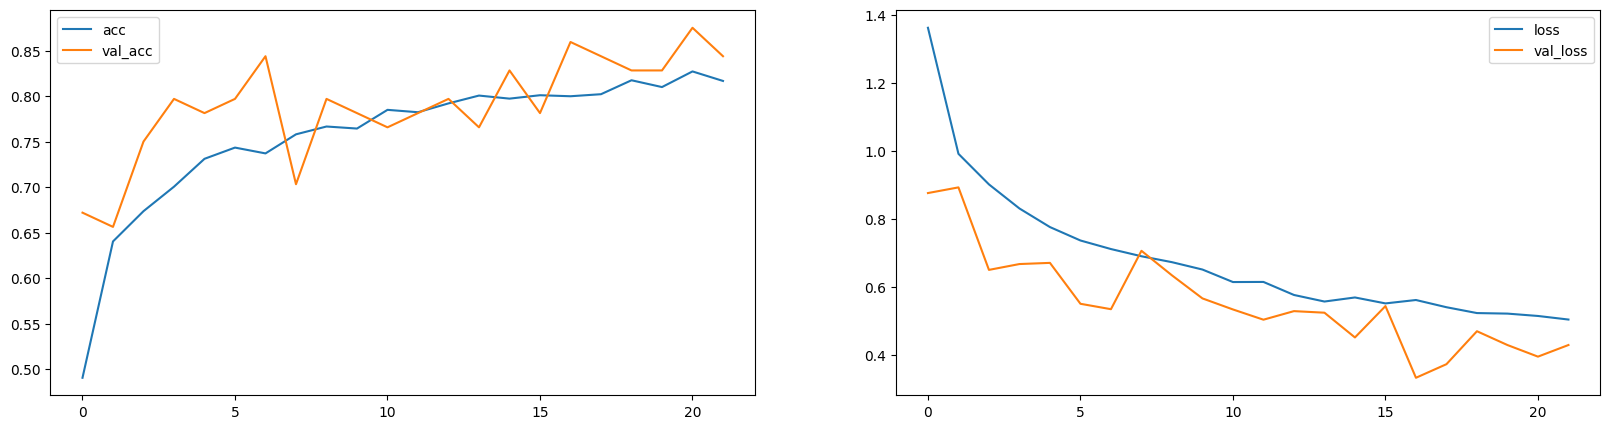

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# Get the predicted probabilities for the validation set
pred_probs = model.predict(validation_generator)

# Convert the probabilities to predicted class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Get the true class labels for the validation set
true_labels = validation_generator.classes

2/2 [==============================] - 26s 9s/step


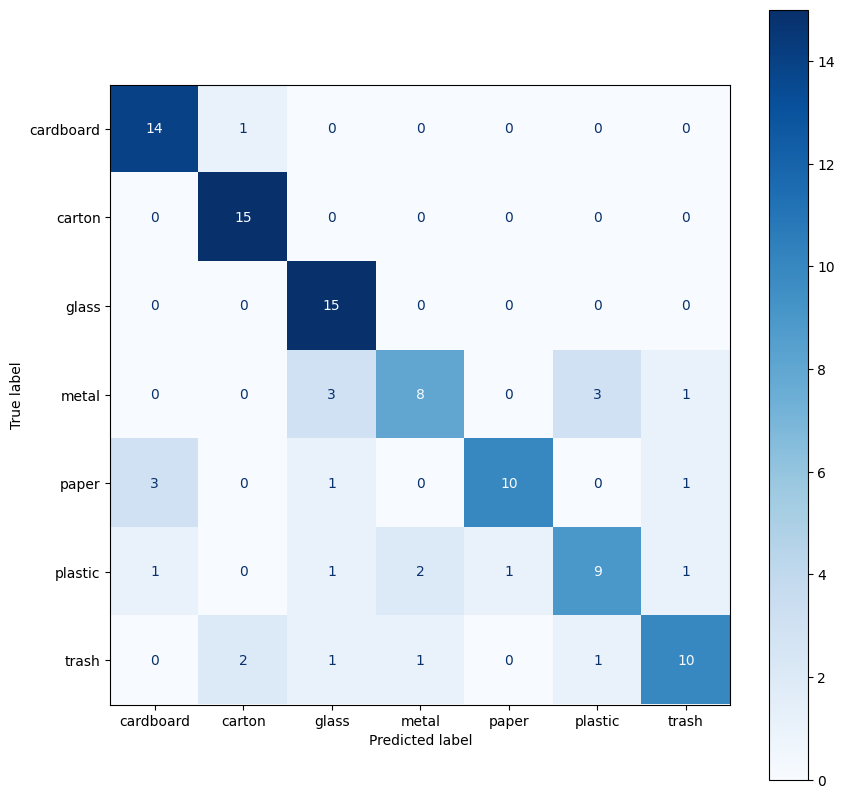

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Get classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)

# Print report
print(report)

              precision    recall  f1-score   support

   cardboard       0.78      0.93      0.85        15
      carton       0.83      1.00      0.91        15
       glass       0.71      1.00      0.83        15
       metal       0.73      0.53      0.62        15
       paper       0.91      0.67      0.77        15
     plastic       0.69      0.60      0.64        15
       trash       0.77      0.67      0.71        15

    accuracy                           0.77       105
   macro avg       0.77      0.77      0.76       105
weighted avg       0.77      0.77      0.76       105

